In [506]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Data Generation

# Generating Models to Ensemble

In [629]:
# first model predicts label mean everywhere

def h1(xs):
    # calculate label mean and duplicate it for each of xs
    return np.tile(np.average(true_ys, axis=0), (len(xs),1))
    

# second model predicts correct linear relationship for first stock and 0 everywhere else
# (for sanity checking purposes)
def h2(xs):
    # build prediction 
    preds = np.zeros((len(xs), feature_dim))
    preds[:,0] = true_ys[:,0]
    return preds

# third model is random
def h3(xs):
    preds = np.random.rand(len(xs), pred_dim)
    return preds

# Create a decision tree regressor
regressor = DecisionTreeRegressor(random_state=42, max_depth=1)
# Train the regressor on the training data
regressor.fit(features, true_ys)
# Make predictions on the testing data
h4 = regressor.predict


In [659]:
print(h(xs).shape)

h3(features).shape

(3, 2)


(10, 2)

## Sanity Check

Using a constant label mean predictor, which debiasing should only run a single round on before quitting.

In [411]:
import debiasedModel
importlib.reload(debiasedModel)

import policies
import importlib 
importlib.reload(policies)

simplex = policies.Simplex(pred_dim)
simplex.run(h2(features));

X_train = features
Y_train = true_ys
init_model = h1
max_depth = 10
policy = simplex

model = debiasedModel.Debiased_model()
model.debias(X_train, Y_train, init_model, max_depth, policy);
model.training_preds[0] == np.mean(Y_train, axis=0);

# Second Sanity Check: Running on fully worked-through example

Consider an extremely simple dataset, with only 3 datapoints, constructed so that we can easily hand-check the debiasing process.

In [649]:
importlib.reload(debiasedModel)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [1,0], [1,0]])

def h(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([5,10])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([9,0])
    return np.array(preds)

max_depth = 8
pred_dim = 2
simp = policies.Simplex(pred_dim)
model = debiasedModel.Debiased_model()
model.debias(xs, ys, h, max_depth, simp);

Round of debiasing: 
012345
Model debiasing complete, halting early after round 6/8.


Debiasing on this should proceed as follows: On the first round, it will subset on the points where the policy chooses (1,0), which corresponds to the second two xs. It will then calculate the bias on these, which is (4,0). Here, we see that it has indeed chosen the correct two points to bucket, recorded their bias term correctly.

It should then create a new model, which predicts the same as the original model, but with an offset of (4,0) for these two points, which it does:

In [650]:
print("Coordinate being debiased:", model.debiasing_cond[0])
print("Points where value is 1 for this coordinate:", model.training_buckets_indices[0][0])
print("Bias on this subset of points: ", model.bias_array[0])
print("Original predictions:")
print(model.training_preds[0])
print("Updated predictions:")
print(model.training_preds[1])

Coordinate being debiased: 0
Points where value is 1 for this coordinate: [1 2]
Bias on this subset of points:  [[4. 0.]]
Original predictions:
[[ 5 10]
 [ 1  0]
 [ 9  0]]
Updated predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]


Next, it will look at the subset of points where this new updated model's policy chooses (0,1). This should correspond to the first two points. This update shouldn't do anything, because the updated model is unbiased on these two points.

In [651]:
print("Coordinate being debiased:", model.debiasing_cond[1])
print("Points where value is 1 for this coordinate:", model.training_buckets_indices[1][0])
print("Bias on this subset of points: ", model.bias_array[1])
print("Previous predictions:")
print(model.training_preds[1])
print("Updated predictions:")
print(model.training_preds[2])

Coordinate being debiased: 1
Points where value is 1 for this coordinate: [0 1]
Bias on this subset of points:  [[0. 0.]]
Previous predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]
Updated predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]


Now, it will recurse back to check on the points where the model chooses (1,0). This corresponds to the last (third) point, and the model *is* biased on these, with bias (4,0), so it will correct itself.

In [652]:
print("Coordinate being debiased:", model.debiasing_cond[2])
print("Points where value is 1 for this coordinate:", model.training_buckets_indices[2][0])
print("Bias on this subset of points: ", model.bias_array[2])
print("Previous predictions:")
print(model.training_preds[2])
print("Updated predictions:")
print(model.training_preds[3])

Coordinate being debiased: 0
Points where value is 1 for this coordinate: [2]
Bias on this subset of points:  [[4. 0.]]
Previous predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]
Updated predictions:
[[ 5 10]
 [-3  0]
 [ 1  0]]


The model is now unbiased conditional on both the places where the policy chooses (0,1) and where it chooses (1,0). It has to loop one more time through both (0,1) and (1,0), and will halt after this, with a total of 6 rounds.

In [653]:
model.depth

6

We expect to see the MSE drop in every single round on the training data.

In [654]:
from sklearn.metrics import mean_squared_error as mse 

preds = np.array(model.training_preds)
for i in range(len(model.training_preds)):
    print(mse(ys, model.training_preds[i], multioutput='raw_values'))


[26.66666667  0.        ]
[16.  0.]
[16.  0.]
[10.66666667  0.        ]
[10.66666667  0.        ]
[10.66666667  0.        ]
[10.66666667  0.        ]


# Running on a terrible model

Starting with a model that just randomly guesses on data where labels have linear relationship with features, let's see how debiasing does

In [670]:
import debiasedModel
importlib.reload(debiasedModel)

import policies
import importlib 
importlib.reload(policies)

#this data is garbage but making just to have something to test the whole process with
n= 10
feature_dim = 3
pred_dim = 3

# feature data just normally distributed
features = np.random.normal(size=(n, feature_dim))
# linear relationship between features and labels
slopes = np.random.uniform(size = (feature_dim, pred_dim))
true_ys = np.dot(features, slopes) + np.random.normal(0, 0.1, size=(n, pred_dim))

simplex = policies.Simplex(pred_dim)

X_train = features
Y_train = true_ys
init_model = h3
max_depth = 10

simplex = policies.Simplex(pred_dim)
model = debiasedModel.Debiased_model()
model.debias(X_train, Y_train, init_model, max_depth, simplex);

Round of debiasing: 
0123456789

Text(0, 0.5, 'MSE')

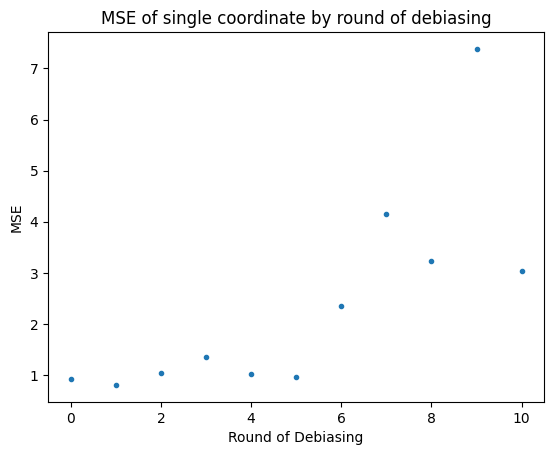

In [684]:
preds = np.array(model.training_preds)
mses = np.zeros((model.depth+1, model.prediction_dim))
for i in range(len(model.training_preds)):
    mses[i] = mse(Y_train, model.training_preds[i], multioutput='raw_values')

coord = 0
plt.plot(np.arange(model.depth+1), mses[:,coord], '.')
plt.title("MSE of single coordinate by round of debiasing")
plt.xlabel("Round of Debiasing")
plt.ylabel("MSE")
#plt.plot(preds[])

In [454]:
#checking unbiasedness
# print(h3(X_train))
# bucket = model.training_buckets_indices[0][0]
# print("subsetting indices:", bucket)
# print()
# print(h3(X_train)[bucket])

# preds = model.training_buckets_preds[0][0]
# ys = Y_train[bucket]
# print()
# print(preds)
# print()
# print(ys)

# np.mean(preds, axis=0) -np.mean(ys, axis=0)

Plotting MSE over time of model

Text(0, 0.5, 'MSE')

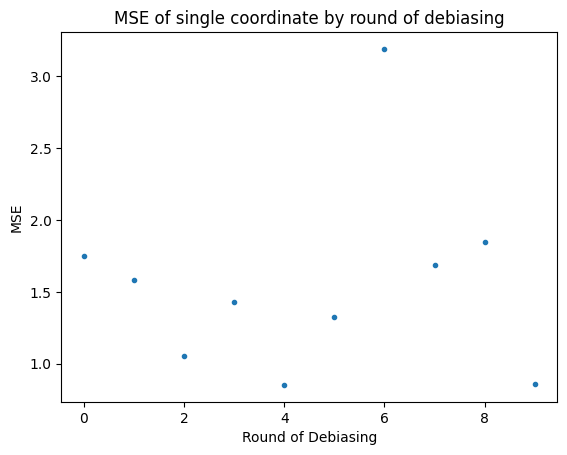

In [644]:
from sklearn.metrics import mean_squared_error as mse 

coord = 1
mse_by_round = np.array([mse(Y_train, model.training_preds[i], multioutput='raw_values') for i in range(model.depth)])
plt.plot(np.arange(model.depth), mse_by_round[:, coord], '.')
plt.title("MSE of single coordinate by round of debiasing")
plt.xlabel("Round of Debiasing")
plt.ylabel("MSE")


In [634]:
coord = 1
arr = np.array(model.bias_array)
#plt.plot(np.arange(model.depth), arr[np.arange(model.depth),coord], '.')
#arr[np.arange(model.depth),coord]
# arr[0]
model.bias_array

array([[[-1.23261509, -0.21946271, -1.40083598]],

       [[ 0.        ,  0.        ,  0.        ]],

       [[ 0.18441005,  0.51266614,  1.028576  ]]])

[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]


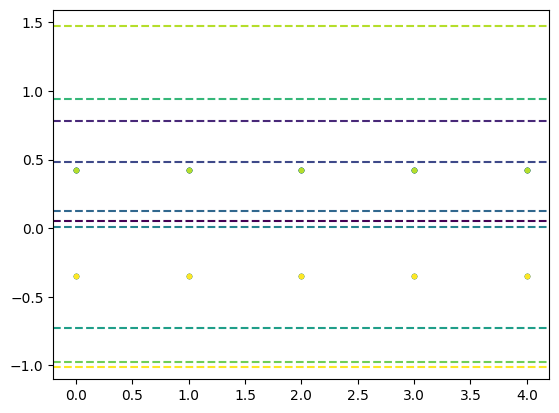

In [453]:
coord = 1

# color each of the datapoints 
num_colors = model.n 
color_palette = plt.cm.viridis(np.linspace(0, 1, num_colors))

# for each round, plot predictions on ith coordinate
preds = np.array(model.training_preds)
for i in range(model.n):
    # print(preds[np.arange(model.depth), i][:,coord])
    # Plot predictions
    plt.plot(np.arange(model.depth), preds[np.arange(model.depth), i][:,coord], '.', color=color_palette[i])
    # Plot the true values of each coordinate as a horizontal line
    plt.axhline(y=Y_train[i][coord], color=color_palette[i], linestyle='--', label='Horizontal Line at y=4');


5